In [1]:
import os
os.chdir('../..')
os.getcwd()

'D:\\StockMaster'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler

In [4]:
import pandas_datareader as pdr
df= pdr.get_data_yahoo('AAPL', '2000-01-01')

In [140]:
df['Close'].diff(1).apply(lambda x : 'UP' if x > 0  else 'Down')

Date
1999-12-31    Down
2000-01-03      UP
2000-01-04    Down
2000-01-05      UP
2000-01-06    Down
              ... 
2020-07-08      UP
2020-07-09      UP
2020-07-10      UP
2020-07-13    Down
2020-07-14      UP
Name: Close, Length: 5166, dtype: object

In [10]:
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout 
import tensorflow.keras.backend as K 
from tensorflow.keras.callbacks import EarlyStopping

In [116]:
# log 정규화
def nplog(dataframe):
    
    temp = np.log(dataframe)
    
    return temp

# indicator 계산
def get_indicators(dataframe, *indicators):
    
    from Indicator import get_Bolinger_Band
    from Indicator import get_DMI
    from Indicator import get_MACD
    from Indicator import get_RSI
    from Indicator import get_OBV
    
    

    BAND = get_Bolinger_Band.fnBolingerBand
    DMI = get_DMI.cal_dmi
    MACD = get_MACD.fnMACD
    RSI = get_RSI.fnRSI
    OBV = get_OBV.faster_OBV
    
    
    for indicator in indicators:
        
        if indicator == 'DMI':
            DMI(dataframe)
        elif indicator == 'MACD':
            MACD(dataframe)
        elif indicator == 'RSI':
            RSI(dataframe)
        elif indicator == 'BAND':
            BAND(dataframe)
        elif indicator == 'OBV':
            OBV(dataframe)
    
    dataframe.dropna(inplace=True)
    
    return dataframe

# minmax scale
def make_sc_col_df(train_scdf):
    for i in train_scdf.columns:
        globals()['scaler_{}'.format(i)] = MinMaxScaler()
        print("df_{}".format(i))
        globals()["df_{}".format(i)] = train_scdf[[i]]
        globals()["df_{}".format(i)] = globals()['scaler_{}'.format(i)].fit_transform(globals()["df_{}".format(i)])
        globals()["df_{}".format(i)] = pd.DataFrame(globals()["df_{}".format(i)])
        globals()["df_{}".format(i)].index = train_scdf.index
        globals()["df_{}".format(i)].columns = [i]

    return globals()["df_{}".format(i)]

# shift data
def shift_df(*dataframes, start=1, end=6):  
    shift_num = end
    for dataframe in dataframes:
        for s in range(start, end):
            dataframe['shift_{}'.format(s)] = dataframe[dataframe.columns[0]].shift(s)
        dataframe.dropna(inplace=True)
    return dataframe

# concat dataframe
def df_concat(*dataframes):
    all_Df =  pd.concat([*dataframes], axis=1)
    all_Df.dropna(inplace=True)
    return all_Df

# drop original values
def drop_ori_cols(all_df):
    col_list = []
    for i in all_df.columns:
        if 'shift' in i:
            pass
        elif 'Close' in i:
            pass
        else:
            col_list.append(i)
    all_df.drop(col_list, axis=1, inplace=True)
    
    return all_df

# set y target & split train test
def set_split(all_df, num=10, xnum=200):
    xdata = all_df.drop('Close', axis=1)[:-num]
    ydata = all_df['Close'][num:].values
    
    x_train = xdata[:-xnum]
    x_test = xdata[-xnum:]

    ytrain = ydata[:-xnum]
    ytest = ydata[-xnum:]
    
    shift_num = 5
    x_train = np.array(x_train).reshape(len(x_train), int(len(x_train.columns)/shift_num), shift_num)
    x_test = np.array(x_test).reshape(len(x_test), int(len(x_test.columns)/shift_num), shift_num)

    
    return x_train, x_test, ytrain, ytest

# make LSTM model
def LSTMmodel():

    model3 = Sequential() # Sequeatial Model 
    model3.add(LSTM(20, input_shape=(x_train.shape[1], x_train.shape[2]))) # (timestep, feature) 
    model3.add(Dense(1)) # output = 1 
    model3.compile(loss='mean_squared_error', optimizer='adam') 
    model3.summary()
    
    return model3

# inverse predict 
def get_real(pred, scaler_Close):
    
    real = np.exp(scaler_Close.inverse_transform(pred))
    real = pd.DataFrame(real, columns = pred.columns)
    real['err'] = real['real'] - real['pred']
    
    return real

# model save
def save(model, name):
    # 전체 모델을 HDF5 파일로 저장합니다
    model.save('./src/parkjunsung/models/' + str(name) + '.h5')

In [117]:
log_df = nplog(df)
indicators = get_indicators(log_df, 'DMI', 'RSI', 'MACD', 'BAND', 'OBV')
make_sc_col_df(indicators)

df_High
df_Low
df_Open
df_Close
df_Volume
df_Adj Close
df_PDI
df_MDI
df_ADX
df_RSI_MACD
df_EMAFast
df_EMASlow
df_MACD
df_MACDSignal
df_MACDDiff
df_20d_ma
df_Bol_upper
df_Bol_lower
df_OBV


,OBV
Date,
2000-02-17,0.195745
2000-02-18,0.192377
2000-02-22,0.195856
2000-02-23,0.199357
2000-02-24,0.195899
...,...
2020-07-08,0.993561
2020-07-09,0.996811
2020-07-10,1.000000


In [118]:
shift_df(
    df_High,
    df_Low,
    df_Open,
    df_Close,
    df_Volume,
    df_PDI,
    df_MDI,
    df_ADX,
    df_RSI_MACD,
    df_EMAFast,
    df_EMASlow,
    df_MACD,
    df_MACDSignal,
    df_MACDDiff,
    df_20d_ma,
    df_Bol_upper,
    df_Bol_lower,
    df_OBV)

,OBV,shift_1,shift_2,shift_3,shift_4,shift_5
Date,,,,,,
2000-02-25,0.192520,0.195899,0.199357,0.195856,0.192377,0.195745
2000-02-28,0.195951,0.192520,0.195899,0.199357,0.195856,0.192377
2000-02-29,0.199405,0.195951,0.192520,0.195899,0.199357,0.195856
2000-03-01,0.203061,0.199405,0.195951,0.192520,0.195899,0.199357
2000-03-02,0.199639,0.203061,0.199405,0.195951,0.192520,0.195899
...,...,...,...,...,...,...
2020-07-08,0.993561,0.990323,0.993553,0.990313,0.990313,0.993540
2020-07-09,0.996811,0.993561,0.990323,0.993553,0.990313,0.990313
2020-07-10,1.000000,0.996811,0.993561,0.990323,0.993553,0.990313


In [119]:
all_df = df_concat(
    df_High,
    df_Low,
    df_Open,
    df_Close,
    df_Volume,
    df_PDI,
    df_MDI,
    df_ADX,
    df_RSI_MACD,
    df_EMAFast,
    df_EMASlow,
    df_MACD,
    df_MACDSignal,
    df_MACDDiff,
    df_20d_ma,
    df_Bol_upper,
    df_Bol_lower,
    df_OBV)

In [120]:
drop_ori_cols(all_df)

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_1,shift_2,shift_3,shift_4,shift_5,...,shift_1,shift_2,shift_3,shift_4,shift_5,shift_1,shift_2,shift_3,shift_4,shift_5
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-25,0.249159,0.248986,0.246096,0.243873,0.244052,0.245074,0.243959,0.237397,0.243772,0.247099,...,0.242393,0.242338,0.242480,0.241964,0.241966,0.195899,0.199357,0.195856,0.192377,0.195745
2000-02-28,0.246185,0.249159,0.248986,0.246096,0.243873,0.242648,0.245074,0.243959,0.237397,0.243772,...,0.242422,0.242393,0.242338,0.242480,0.241964,0.192520,0.195899,0.199357,0.195856,0.192377
2000-02-29,0.243335,0.246185,0.249159,0.248986,0.246096,0.239995,0.242648,0.245074,0.243959,0.237397,...,0.244418,0.242422,0.242393,0.242338,0.242480,0.195951,0.192520,0.195899,0.199357,0.195856
2000-03-01,0.246537,0.243335,0.246185,0.249159,0.248986,0.246273,0.239995,0.242648,0.245074,0.243959,...,0.245923,0.244418,0.242422,0.242393,0.242338,0.199405,0.195951,0.192520,0.195899,0.199357
2000-03-02,0.266199,0.246537,0.243335,0.246185,0.249159,0.254786,0.246273,0.239995,0.242648,0.245074,...,0.246500,0.245923,0.244418,0.242422,0.242393,0.203061,0.199405,0.195951,0.192520,0.195899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-08,0.990996,0.989751,0.987399,0.986006,0.985384,0.996131,0.995077,0.992264,0.992387,0.990598,...,0.996338,0.994959,0.993774,0.991276,0.989612,0.990323,0.993553,0.990313,0.990313,0.993540
2020-07-09,0.992248,0.990996,0.989751,0.987399,0.986006,0.997958,0.996131,0.995077,0.992264,0.992387,...,0.996366,0.996338,0.994959,0.993774,0.991276,0.993561,0.990323,0.993553,0.990313,0.990313
2020-07-10,0.993873,0.992248,0.990996,0.989751,0.987399,0.998980,0.997958,0.996131,0.995077,0.992264,...,0.996014,0.996366,0.996338,0.994959,0.993774,0.996811,0.993561,0.990323,0.993553,0.990313


In [121]:
shift_df(df_Close, df_PDI, df_MDI)

,MDI,shift_1,shift_2,shift_3,shift_4,shift_5
Date,,,,,,
2000-03-03,0.150526,0.157061,0.188388,0.270075,0.301417,0.288893
2000-03-06,0.138778,0.150526,0.157061,0.188388,0.270075,0.301417
2000-03-07,0.222549,0.138778,0.150526,0.157061,0.188388,0.270075
2000-03-08,0.269819,0.222549,0.138778,0.150526,0.157061,0.188388
2000-03-09,0.233214,0.269819,0.222549,0.138778,0.150526,0.157061
...,...,...,...,...,...,...
2020-07-08,0.122902,0.144920,0.162626,0.200528,0.226608,0.240106
2020-07-09,0.108276,0.122902,0.144920,0.162626,0.200528,0.226608
2020-07-10,0.097471,0.108276,0.122902,0.144920,0.162626,0.200528


In [122]:
x_train, x_test, y_train, y_test = set_split(all_df)

In [123]:
model = LSTMmodel()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 20)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 21        
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


In [129]:
model.fit(x_train, y_train, epochs=1000, batch_size=30, verbose=1)

Epoch 1/1000
4918/4918 [==============================] - 2s 451us/sample - loss: 3.9085e-04
Epoch 2/1000
4918/4918 [==============================] - 2s 448us/sample - loss: 3.8953e-04
Epoch 3/1000
4918/4918 [==============================] - 2s 446us/sample - loss: 3.7839e-04
Epoch 4/1000
4918/4918 [==============================] - 2s 450us/sample - loss: 3.6572e-04
Epoch 5/1000
4918/4918 [==============================] - 2s 448us/sample - loss: 3.6006e-04
Epoch 6/1000
4918/4918 [==============================] - 2s 450us/sample - loss: 3.4390e-04
Epoch 7/1000
4918/4918 [==============================] - 2s 446us/sample - loss: 3.2971e-04
Epoch 8/1000
4918/4918 [==============================] - 2s 452us/sample - loss: 3.2693e-04
Epoch 9/1000
4918/4918 [==============================] - 2s 450us/sample - loss: 3.1485e-04
Epoch 10/1000
4918/4918 [==============================] - 2s 447us/sample - loss: 3.2579e-04
Epoch 11/1000
4918/4918 [==============================] - 2s 449us/s

4918/4918 [==============================] - 2s 440us/sample - loss: 2.4772e-04
Epoch 89/1000
4918/4918 [==============================] - 2s 439us/sample - loss: 2.3919e-04
Epoch 90/1000
4918/4918 [==============================] - 2s 439us/sample - loss: 2.4875e-04
Epoch 91/1000
4918/4918 [==============================] - 2s 439us/sample - loss: 2.4621e-04
Epoch 92/1000
4918/4918 [==============================] - 2s 442us/sample - loss: 2.5967e-04
Epoch 93/1000
4918/4918 [==============================] - 2s 440us/sample - loss: 2.4591e-04
Epoch 94/1000
4918/4918 [==============================] - 2s 441us/sample - loss: 2.4935e-04
Epoch 95/1000
4918/4918 [==============================] - 2s 441us/sample - loss: 2.5520e-04
Epoch 96/1000
4918/4918 [==============================] - 2s 439us/sample - loss: 2.5175e-04
Epoch 97/1000
4918/4918 [==============================] - 2s 442us/sample - loss: 2.4769e-04
Epoch 98/1000
4918/4918 [==============================] - 2s 442us/sample

4918/4918 [==============================] - 2s 438us/sample - loss: 2.2096e-04
Epoch 175/1000
4918/4918 [==============================] - 2s 438us/sample - loss: 2.2554e-04
Epoch 176/1000
4918/4918 [==============================] - 2s 438us/sample - loss: 2.1764e-04
Epoch 177/1000
4918/4918 [==============================] - 2s 435us/sample - loss: 2.2482e-04
Epoch 178/1000
4918/4918 [==============================] - 2s 437us/sample - loss: 2.2705e-04
Epoch 179/1000
4918/4918 [==============================] - 2s 437us/sample - loss: 2.1735e-04
Epoch 180/1000
4918/4918 [==============================] - 2s 435us/sample - loss: 2.3151e-04
Epoch 181/1000
4918/4918 [==============================] - 2s 435us/sample - loss: 2.1798e-04
Epoch 182/1000
4918/4918 [==============================] - 2s 438us/sample - loss: 2.2345e-04
Epoch 183/1000
4918/4918 [==============================] - 2s 434us/sample - loss: 2.2535e-04
Epoch 184/1000
4918/4918 [==============================] - 2s 43

4918/4918 [==============================] - 2s 438us/sample - loss: 2.0601e-04
Epoch 261/1000
4918/4918 [==============================] - 2s 445us/sample - loss: 2.1417e-04
Epoch 262/1000
4918/4918 [==============================] - 2s 443us/sample - loss: 2.0453e-04
Epoch 263/1000
4918/4918 [==============================] - 2s 436us/sample - loss: 1.9720e-04
Epoch 264/1000
4918/4918 [==============================] - 2s 436us/sample - loss: 1.9489e-04
Epoch 265/1000
4918/4918 [==============================] - 2s 436us/sample - loss: 2.0222e-04
Epoch 266/1000
4918/4918 [==============================] - 2s 439us/sample - loss: 2.0594e-04
Epoch 267/1000
4918/4918 [==============================] - 2s 437us/sample - loss: 2.0529e-04
Epoch 268/1000
4918/4918 [==============================] - 2s 438us/sample - loss: 2.0797e-04
Epoch 269/1000
4918/4918 [==============================] - 2s 436us/sample - loss: 1.9483e-04
Epoch 270/1000
4918/4918 [==============================] - 2s 43

4918/4918 [==============================] - 2s 439us/sample - loss: 1.6041e-04
Epoch 347/1000
4918/4918 [==============================] - 2s 443us/sample - loss: 1.7266e-04
Epoch 348/1000
4918/4918 [==============================] - 2s 438us/sample - loss: 1.6335e-04
Epoch 349/1000
4918/4918 [==============================] - 2s 438us/sample - loss: 1.7237e-04
Epoch 350/1000
4918/4918 [==============================] - 2s 438us/sample - loss: 1.6937e-04
Epoch 351/1000
4918/4918 [==============================] - 2s 437us/sample - loss: 1.5859e-04
Epoch 352/1000
4918/4918 [==============================] - 2s 438us/sample - loss: 1.6024e-04
Epoch 353/1000
4918/4918 [==============================] - 2s 437us/sample - loss: 1.5356e-04
Epoch 354/1000
4918/4918 [==============================] - 2s 439us/sample - loss: 1.6103e-04
Epoch 355/1000
4918/4918 [==============================] - 2s 438us/sample - loss: 1.6534e-04
Epoch 356/1000
4918/4918 [==============================] - 2s 43

4918/4918 [==============================] - 2s 432us/sample - loss: 1.4927e-04
Epoch 433/1000
4918/4918 [==============================] - 2s 430us/sample - loss: 1.4059e-04
Epoch 434/1000
4918/4918 [==============================] - 2s 430us/sample - loss: 1.4595e-04
Epoch 435/1000
4918/4918 [==============================] - 2s 428us/sample - loss: 1.3875e-04
Epoch 436/1000
4918/4918 [==============================] - 2s 431us/sample - loss: 1.5118e-04
Epoch 437/1000
4918/4918 [==============================] - 2s 432us/sample - loss: 1.3869e-04
Epoch 438/1000
4918/4918 [==============================] - 2s 431us/sample - loss: 1.4505e-04
Epoch 439/1000
4918/4918 [==============================] - 2s 431us/sample - loss: 1.3828e-04
Epoch 440/1000
4918/4918 [==============================] - 2s 430us/sample - loss: 1.3412e-04
Epoch 441/1000
4918/4918 [==============================] - 2s 432us/sample - loss: 1.4571e-04
Epoch 442/1000
4918/4918 [==============================] - 2s 43

4918/4918 [==============================] - 2s 444us/sample - loss: 1.2781e-04
Epoch 519/1000
4918/4918 [==============================] - 2s 443us/sample - loss: 1.2679e-04
Epoch 520/1000
4918/4918 [==============================] - 2s 442us/sample - loss: 1.3031e-04
Epoch 521/1000
4918/4918 [==============================] - 2s 433us/sample - loss: 1.2845e-04
Epoch 522/1000
4918/4918 [==============================] - 2s 432us/sample - loss: 1.3889e-04
Epoch 523/1000
4918/4918 [==============================] - 2s 450us/sample - loss: 1.3209e-04
Epoch 524/1000
4918/4918 [==============================] - 2s 447us/sample - loss: 1.2884e-04
Epoch 525/1000
4918/4918 [==============================] - 2s 477us/sample - loss: 1.2514e-04
Epoch 526/1000
4918/4918 [==============================] - 2s 475us/sample - loss: 1.2674e-04
Epoch 527/1000
4918/4918 [==============================] - 2s 458us/sample - loss: 1.2722e-04
Epoch 528/1000
4918/4918 [==============================] - 2s 44

4918/4918 [==============================] - 2s 459us/sample - loss: 1.2187e-04s - loss: 1.2252e-
Epoch 604/1000
4918/4918 [==============================] - 2s 486us/sample - loss: 1.1721e-04
Epoch 605/1000
4918/4918 [==============================] - 2s 488us/sample - loss: 1.1573e-04
Epoch 606/1000
4918/4918 [==============================] - 2s 427us/sample - loss: 1.1651e-04
Epoch 607/1000
4918/4918 [==============================] - 2s 423us/sample - loss: 1.1560e-04
Epoch 608/1000
4918/4918 [==============================] - 2s 432us/sample - loss: 1.4479e-04
Epoch 609/1000
4918/4918 [==============================] - 2s 484us/sample - loss: 1.2080e-04
Epoch 610/1000
4918/4918 [==============================] - 2s 429us/sample - loss: 1.2224e-04
Epoch 611/1000
4918/4918 [==============================] - 2s 434us/sample - loss: 1.1774e-04
Epoch 612/1000
4918/4918 [==============================] - 2s 487us/sample - loss: 1.1523e-04
Epoch 613/1000
4918/4918 [=====================

4918/4918 [==============================] - 2s 444us/sample - loss: 1.1844e-04
Epoch 689/1000
4918/4918 [==============================] - 2s 442us/sample - loss: 1.0739e-04
Epoch 690/1000
4918/4918 [==============================] - 2s 442us/sample - loss: 1.1219e-04
Epoch 691/1000
4918/4918 [==============================] - 2s 438us/sample - loss: 1.0615e-04
Epoch 692/1000
4918/4918 [==============================] - 2s 441us/sample - loss: 1.0642e-04
Epoch 693/1000
4918/4918 [==============================] - 2s 439us/sample - loss: 1.0788e-04
Epoch 694/1000
4918/4918 [==============================] - 2s 434us/sample - loss: 1.0672e-04
Epoch 695/1000
4918/4918 [==============================] - 2s 434us/sample - loss: 1.0786e-04
Epoch 696/1000
4918/4918 [==============================] - 2s 436us/sample - loss: 1.0976e-04
Epoch 697/1000
4918/4918 [==============================] - 2s 442us/sample - loss: 1.0640e-04
Epoch 698/1000
4918/4918 [==============================] - 2s 44

4918/4918 [==============================] - 2s 419us/sample - loss: 9.8001e-05
Epoch 775/1000
4918/4918 [==============================] - 2s 421us/sample - loss: 9.6820e-05
Epoch 776/1000
4918/4918 [==============================] - 2s 420us/sample - loss: 9.5938e-05
Epoch 777/1000
4918/4918 [==============================] - 2s 420us/sample - loss: 9.5953e-05
Epoch 778/1000
4918/4918 [==============================] - 2s 420us/sample - loss: 1.0165e-04s 
Epoch 779/1000
4918/4918 [==============================] - 2s 420us/sample - loss: 9.6232e-05
Epoch 780/1000
4918/4918 [==============================] - 2s 422us/sample - loss: 9.5892e-05
Epoch 781/1000
4918/4918 [==============================] - 2s 421us/sample - loss: 9.7715e-05
Epoch 782/1000
4918/4918 [==============================] - 2s 421us/sample - loss: 9.7531e-05
Epoch 783/1000
4918/4918 [==============================] - 2s 422us/sample - loss: 9.7945e-05
Epoch 784/1000
4918/4918 [==============================] - 2s 

4918/4918 [==============================] - 2s 430us/sample - loss: 8.7589e-05
Epoch 860/1000
4918/4918 [==============================] - 2s 433us/sample - loss: 8.6007e-05
Epoch 861/1000
4918/4918 [==============================] - 2s 441us/sample - loss: 8.8902e-05
Epoch 862/1000
4918/4918 [==============================] - 2s 435us/sample - loss: 8.7299e-05
Epoch 863/1000
4918/4918 [==============================] - 2s 435us/sample - loss: 8.6874e-05
Epoch 864/1000
4918/4918 [==============================] - 2s 427us/sample - loss: 8.5178e-05
Epoch 865/1000
4918/4918 [==============================] - 2s 433us/sample - loss: 8.5771e-05
Epoch 866/1000
4918/4918 [==============================] - 2s 438us/sample - loss: 8.5953e-05
Epoch 867/1000
4918/4918 [==============================] - 2s 438us/sample - loss: 8.5286e-05
Epoch 868/1000
4918/4918 [==============================] - 2s 430us/sample - loss: 8.5617e-05
Epoch 869/1000
4918/4918 [==============================] - 2s 44

4918/4918 [==============================] - 2s 422us/sample - loss: 7.8633e-05
Epoch 946/1000
4918/4918 [==============================] - 2s 423us/sample - loss: 7.7153e-05
Epoch 947/1000
4918/4918 [==============================] - 2s 422us/sample - loss: 8.0142e-05
Epoch 948/1000
4918/4918 [==============================] - 2s 421us/sample - loss: 7.8313e-05
Epoch 949/1000
4918/4918 [==============================] - 2s 419us/sample - loss: 7.6730e-05
Epoch 950/1000
4918/4918 [==============================] - 2s 422us/sample - loss: 7.8051e-05
Epoch 951/1000
4918/4918 [==============================] - 2s 421us/sample - loss: 8.0256e-05
Epoch 952/1000
4918/4918 [==============================] - 2s 419us/sample - loss: 7.7859e-05
Epoch 953/1000
4918/4918 [==============================] - 2s 421us/sample - loss: 7.7664e-05
Epoch 954/1000
4918/4918 [==============================] - 2s 422us/sample - loss: 7.4254e-05
Epoch 955/1000
4918/4918 [==============================] - 2s 42

In [125]:
pred = pd.DataFrame(model.predict(x_test), columns = ['pred'])

In [126]:
pred['real'] = y_test

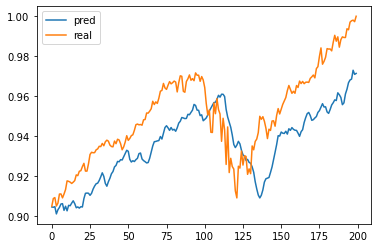

In [127]:
pred.plot()

In [91]:
pred['err'] = pred['pred'] - pred['real']

In [92]:
pred.describe()

,pred,real,err
count,200.000000,200.000000,200.000000
mean,0.950321,0.950251,0.000071
std,0.019723,0.022679,0.007002
min,0.913294,0.904862,-0.015819
25%,0.937102,0.934600,-0.004369
50%,0.952290,0.950094,-0.001105
75%,0.965736,0.967027,0.003145
max,0.990997,1.000000,0.026420


In [94]:
get_real1 = get_real(pred[['pred', 'real']], scaler_Close)

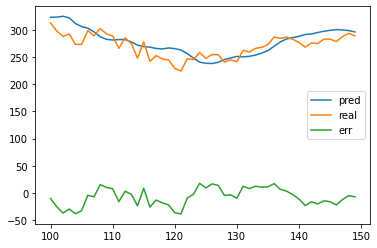

In [97]:
get_real1[100:150].plot()

In [87]:
save(model, 'stock_master_all_indicators')

In [31]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1999-12-31,3.674107,3.553571,3.604911,3.671875,40952800.0,3.178732
2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,3.460857
2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,3.169071
2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,3.215448
2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.937188
...,...,...,...,...,...,...
2020-07-06,375.779999,369.869995,370.000000,373.850006,29663900.0,373.850006
2020-07-07,378.619995,372.230011,375.410004,372.690002,28106100.0,372.690002
2020-07-08,381.500000,376.359985,376.720001,381.369995,29273000.0,381.369995


In [ ]:
target = df[['Close']][-1:]
target

In [ ]:
def future_stock(target):
    for s in range(1, 2):
        dataframe['shift_{}'.format(s)] = dataframe[dataframe.columns[0]].shift(s)

In [67]:
target

,Close,shift_1,shift_2
Date,,,
2020-07-10,383.679993,383.01001,381.369995


In [39]:
logg = nplog(target)

In [48]:
sc_test = scaler_Close.transform(logg)

In [58]:
sc_test = sc_test.reshape(1, sc_test.shape[0], sc_test.shape[1])

In [59]:
sc_test

array([[[1.        , 0.99970943]]])

In [60]:
model.predict(sc_test)

array([[1.0028166]], dtype=float32)

In [63]:
real = np.exp(scaler_Close.inverse_transform(model.predict(sc_test)))

In [64]:
real

array([[390.2352]], dtype=float32)

In [128]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
4918/4918 [==============================] - 11s 2ms/sample - loss: 0.0248
Epoch 2/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 0.0068 0s - los
Epoch 3/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 0.0043
Epoch 4/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 0.0038
Epoch 5/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 0.0030
Epoch 6/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 0.0027
Epoch 7/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 0.0026
Epoch 8/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 0.0024
Epoch 9/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 0.0022
Epoch 10/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 0.0021
Epoch 11/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 0.0021 0s - loss: 0.002
Epoch 12/100
4918/4918 [=

4918/4918 [==============================] - 7s 1ms/sample - loss: 7.7382e-04
Epoch 92/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 7.9579e-04
Epoch 93/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 8.0362e-04
Epoch 94/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 8.8365e-04
Epoch 95/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 7.9943e-04
Epoch 96/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 8.0160e-04
Epoch 97/100
4918/4918 [==============================] - 8s 2ms/sample - loss: 8.0308e-04
Epoch 98/100
4918/4918 [==============================] - 7s 2ms/sample - loss: 7.5741e-04
Epoch 99/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 7.9385e-04
Epoch 100/100
4918/4918 [==============================] - 7s 1ms/sample - loss: 7.9714e-04


In [100]:
pred1 = pd.DataFrame(regressor.predict(x_test), columns = ['pred'])

In [101]:
pred1['real'] = y_test

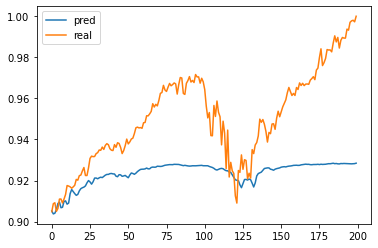

In [102]:
pred1.plot()